In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

In [4]:
import yfinance as yf

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
# get data of the Apple stock (AAPL)
data = yf.download('AAPL', '2019-01-01', '2020-5-14')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,158.529999,159.360001,156.479996,157.740005,154.618546,35003500
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800


In [7]:
#extract the Close price column to plot
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any()

False

In [8]:
# import matplotlib package for date plots
months = mdates.MonthLocator() #get every year
dateFmt = mdates.DateFormatter('%Y-%m') # set year format


In [9]:
# get stock of Apple, Google, Micro, Amazon, FB via Yahoo Finance
def get_close_stock_price(codes, start_date='2018-01-01', end_date='2020-05-14'):
    data = {code : yf.download(code, start_date, end_date) for code in codes }
    data = {key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items()}
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

#df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
#df = get_close_stock_price(['AAPL', 'MSFT', 'FB'])
df = get_close_stock_price(['GOOGL', 'AMZN'])
df.to_csv('data/close_price_GOOGL_AMZN.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

In [11]:
df = pd.read_csv('data/close_price_GOOGL_AMZN.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,GOOGL,AMZN
Date,,
2018-01-02,1073.209961,1189.010010
2018-01-03,1091.520020,1204.199951
2018-01-04,1095.760010,1209.589966
2018-01-05,1110.290039,1229.140015
2018-01-08,1114.209961,1246.869995


In [12]:
def get_feature(raw_df):
    return np.power(raw_df,2).values.reshape(-1)

In [13]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( get_feature(df.iloc[row_idx-history:row_idx,:]))
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=10)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

In [14]:
# Create a Linear Regression Model to predict stock price
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)


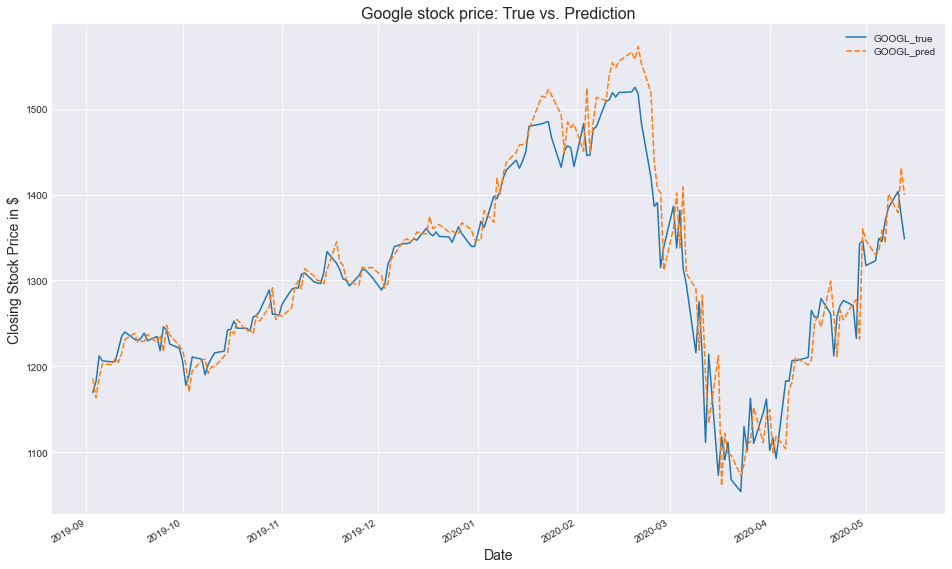

In [15]:

df_plot = pd.DataFrame({"GOOGL_true": y_test[:,0], 'GOOGL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Google stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [16]:
# GOOGLE
print(df_plot)

             GOOGL_true   GOOGL_pred
2019-09-03  1169.550049  1186.062217
2019-09-04  1182.270020  1163.411658
2019-09-05  1212.189941  1186.855235
2019-09-06  1206.319946  1203.153367
2019-09-09  1205.270020  1201.761857
...                 ...          ...
2020-05-07  1369.280029  1343.939018
2020-05-08  1384.339966  1400.677878
2020-05-11  1403.589966  1378.809826
2020-05-12  1375.180054  1431.089251
2020-05-13  1348.329956  1400.002160

[176 rows x 2 columns]


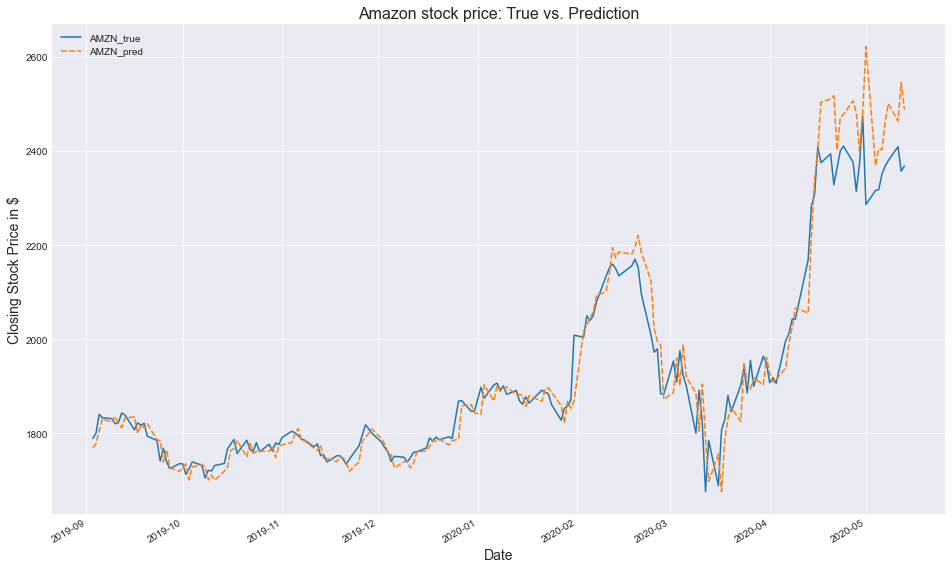

In [17]:
df_plot = pd.DataFrame({"AMZN_true": y_test[:,1], 'AMZN_pred': ypred[:,1]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Amazon stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [18]:
# AMZN
print(df_plot)

              AMZN_true    AMZN_pred
2019-09-03  1789.839966  1769.698010
2019-09-04  1800.619995  1778.203960
2019-09-05  1840.719971  1805.612093
2019-09-06  1833.510010  1831.169098
2019-09-09  1831.349976  1823.979778
...                 ...          ...
2020-05-07  2367.610107  2460.839033
2020-05-08  2379.610107  2500.095815
2020-05-11  2409.000000  2463.159160
2020-05-12  2356.949951  2545.721156
2020-05-13  2367.919922  2488.241260

[176 rows x 2 columns]


In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
for i in range(2):
    print( df.columns[i], mean_relative_error(y_test[:,i], ypred[:,i]))

GOOGL 0.0182207885092836
AMZN 0.017529425089439957


In [21]:
df = get_close_stock_price(['AAPL', 'MSFT', 'FB', 'GOOGL', 'AMZN'])
df.to_csv('data/close_price_big5.csv')
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


False

In [22]:

df = pd.read_csv('data/close_price_big5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,MSFT,FB,GOOGL,AMZN
Date,,,,,
2018-01-02,172.259995,85.949997,181.419998,1073.209961,1189.010010
2018-01-03,172.229996,86.349998,184.669998,1091.520020,1204.199951
2018-01-04,173.029999,87.110001,184.330002,1095.760010,1209.589966
2018-01-05,175.000000,88.190002,186.850006,1110.290039,1229.140015
2018-01-08,174.350006,88.279999,188.279999,1114.209961,1246.869995


In [23]:
def get_feature_(raw_df):
    return np.power(raw_df,2).values.reshape(-1)
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( get_feature(df.iloc[row_idx-history:row_idx,:]))
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=5)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

In [24]:
# Create a Linear Regression Model to predict stock price
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)


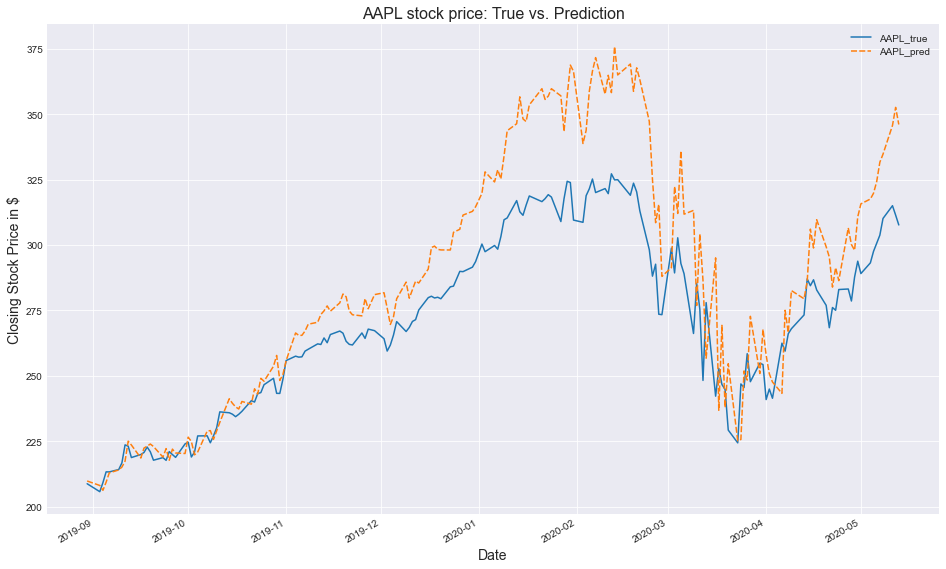

In [25]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('AAPL stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

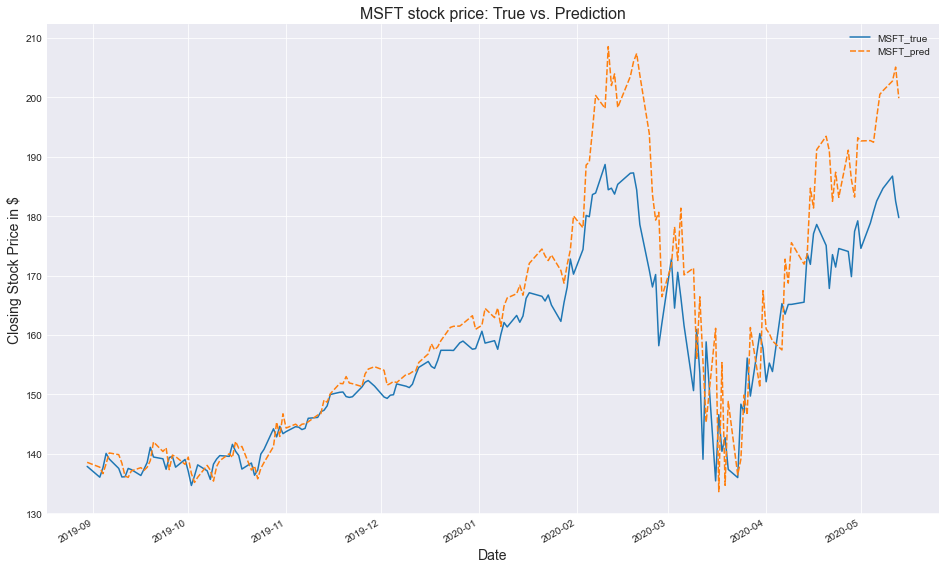

In [26]:
df_plot = pd.DataFrame({"MSFT_true": y_test[:,1], 'MSFT_pred': ypred[:,1]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('MSFT stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

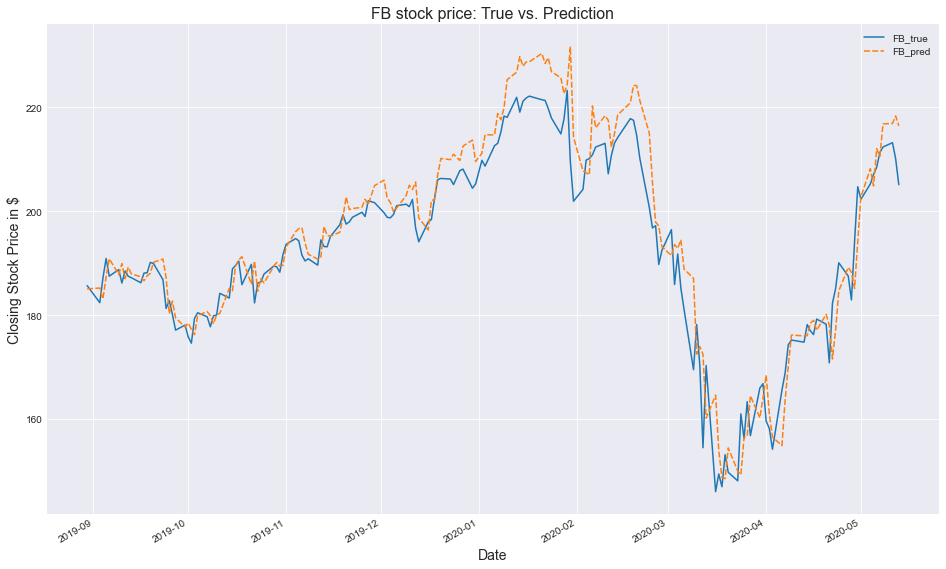

In [27]:
df_plot = pd.DataFrame({"FB_true": y_test[:, 2], 'FB_pred': ypred[:,2]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('FB stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
for i in range(3):
    print( df.columns[i], mean_relative_error(y_test[:,i], ypred[:,i]))

AAPL 0.06181420158670591
MSFT 0.039296310669076684
FB 0.022878344244253425
